# Task 1 of Assignment 2

**Objective:** Train separate models for pathology groups to leverage shared or unique characteristics

**Split Ratio:** 5:3:2 (50% training, 30% validation, 20% testing), applied independently per group

**Pathology Grouping:**

- Lung Diseases: Atelectasis, Consolidation, Edema, Lung Opacity, Pneumonia, Lung Lesion (6)

- Pleural-Related: Effusion, Pleural Other, Pneumothorax (3)

- Cardiac and Mediastinal: Cardiomegaly, Enlarged Cardiomediastinum (2)

- Fracture: Fracture (1)

- Support Devices: Support Devices (1)

**Key Features:**

- Data split with fixed seed (seed=42) for consistency
- NaN values converted to 0, unrecognized pathologies defaulted to 0
- Outputs dictionary with 5 groups, each containing train/validation/test datasets

### 1. Load Data

In [12]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set TensorFlow logging level to suppress unnecessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Helper function: Load embeddings from TFRecord files
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    embedding = torch.tensor(embedding_values)
    if torch.isnan(embedding).any() or torch.isinf(embedding).any():
        raise ValueError(f"NaN or Inf found in embedding: {embedding_path}")
    return embedding

# Custom dataset class for MIMIC chest X-ray embeddings with grouped pathologies
class MIMIC_Embed_Dataset(Dataset):
    pathology_groups = {
        "Lung Diseases": ["Atelectasis", "Consolidation", "Edema", "Lung Opacity", "Pneumonia", "Lung Lesion"],
        "Pleural-Related": ["Pleural Effusion", "Pleural Other", "Pneumothorax"],
        "Cardiac and Mediastinal": ["Cardiomegaly", "Enlarged Cardiomediastinum"],
        "Fracture": ["Fracture"],
        "Support Devices": ["Support Devices"]
    }

    def __init__(self, embedpath, csvpath, metacsvpath, group_name, views=["PA"], mode="train", seed=42, split_ratio=[0.5, 0.3, 0.2], unique_patients=True):
        super().__init__()
        np.random.seed(seed)
        self.group_name = group_name
        self.pathologies = self.pathology_groups[group_name]
        self.mode = mode
        self.embedpath = embedpath
        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.split_ratio = split_ratio

        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        n_row = self.csv.shape[0]
        if self.mode == "train":
            self.csv = self.csv[:int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[int(n_row * self.split_ratio[0]):int(n_row * (self.split_ratio[0] + self.split_ratio[1]))]
        elif self.mode == "test":
            self.csv = self.csv[int(n_row * (self.split_ratio[0] + self.split_ratio[1])):]
        else:
            raise ValueError(f"mode must be one of [train, valid, test], got {self.mode}")

        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            else:
                mask = pd.Series(0, index=self.csv.index)
            labels.append(mask.values)
        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[np.isnan(self.labels)] = 0
        self.labels = np.where((self.labels != 0) & (self.labels != 1), 0, self.labels)
        

        self.csv = self.csv.reset_index(drop=True)
        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def limit_to_selected_views(self, views):
        if not isinstance(views, list):
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        embed_file = os.path.join(self.embedpath, f"p{subjectid[:2]}", f"p{subjectid}", f"s{studyid}", f"{dicom_id}.tfrecord")
        sample["embedding"] = load_embedding(embed_file)
        return sample

# Function to initialize datasets
def initialize_mimic_datasets(embedpath, csvpath, metacsvpath, seed=42, split_ratio=[0.5, 0.3, 0.2]):
    dataset_dict = {}
    group_names = ["Lung Diseases", "Pleural-Related", "Cardiac and Mediastinal", "Fracture", "Support Devices"]
    
    for group in group_names:
        dataset_dict[group] = {
            "train": MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, group, mode="train", seed=seed, split_ratio=split_ratio),
            "valid": MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, group, mode="valid", seed=seed, split_ratio=split_ratio),
            "test": MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, group, mode="test", seed=seed, split_ratio=split_ratio)
        }
    
    return dataset_dict

# Function to print dataset details
def print_dataset_details(datasets, num_samples=3):
    """
    Print details about the datasets to understand their structure and content.
    
    Args:
        datasets (dict): Dictionary of datasets for each pathology group
        num_samples (int): Number of samples to print per dataset
    """
    for group_name, splits in datasets.items():
        print(f"\n=== {group_name} ===")
        for split_name, dataset in splits.items():
            print(f"\n{split_name} Dataset:")
            print(f"Size: {len(dataset)} samples")
            print(f"Pathologies: {dataset.pathologies}")
            print(f"Label shape: {dataset.labels.shape}")
            
            # Print label distribution
            label_means = np.mean(dataset.labels, axis=0)
            print("Label distribution (mean per pathology):")
            for pathology, mean in zip(dataset.pathologies, label_means):
                print(f"  {pathology}: {mean:.3f}")
            
            # Print a few samples
            print(f"\nFirst {min(num_samples, len(dataset))} samples:")
            for i in range(min(num_samples, len(dataset))):
                sample = dataset[i]
                print(f"Sample {i}:")
                print(f"  Index: {sample['idx']}")
                print(f"  Labels: {sample['lab']}")
                print(f"  Embedding shape: {sample['embedding'].shape}")
                print(f"  Embedding (first 5 values): {sample['embedding'][:5]}")
            print("-" * 50)

# Example usage
embedpath = "C:/Users/shery/Downloads/assignment2/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "C:/Users/shery/Downloads/assignment2/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "C:/Users/shery/Downloads/assignment2/mimic-cxr-2.0.0-metadata.csv"

datasets = initialize_mimic_datasets(
    embedpath=embedpath,
    csvpath=csvpath,
    metacsvpath=metacsvpath,
    seed=42,
    split_ratio=[0.5, 0.3, 0.2]
)

# Print details about the datasets
print_dataset_details(datasets, num_samples=3)




=== Lung Diseases ===

train Dataset:
Size: 22814 samples
Pathologies: ['Atelectasis', 'Consolidation', 'Edema', 'Lung Opacity', 'Pneumonia', 'Lung Lesion']
Label shape: (22814, 6)
Label distribution (mean per pathology):
  Atelectasis: 0.088
  Consolidation: 0.018
  Edema: 0.025
  Lung Opacity: 0.118
  Pneumonia: 0.046
  Lung Lesion: 0.029

First 3 samples:
Sample 0:
  Index: 0
  Labels: [0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([ 0.1257, -1.8030,  1.2843, -1.8088,  0.1278])
Sample 1:
  Index: 1
  Labels: [0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([-0.0282, -1.4541,  1.1770, -2.3273,  0.1422])
Sample 2:
  Index: 2
  Labels: [0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([-0.7325, -2.4499,  1.2821, -2.6194,  0.5554])
--------------------------------------------------

valid Dataset:
Size: 13688 samples
Pathologies: ['Atelectasis', 'Co

Sample 0:
  Index: 0
  Labels: [0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([-0.3652, -2.5650,  0.6876, -1.2731, -0.2195])
Sample 1:
  Index: 1
  Labels: [0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([-0.2942, -1.2802,  0.9662, -0.7768,  0.7946])
Sample 2:
  Index: 2
  Labels: [0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([ 0.1063, -1.1377,  1.6448, -1.6789,  0.0252])
--------------------------------------------------

=== Support Devices ===

train Dataset:
Size: 22814 samples
Pathologies: ['Support Devices']
Label shape: (22814, 1)
Label distribution (mean per pathology):
  Support Devices: 0.044

First 3 samples:
Sample 0:
  Index: 0
  Labels: [0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([ 0.1257, -1.8030,  1.2843, -1.8088,  0.1278])
Sample 1:
  Index: 1
  Labels: [0.]
  Embedding shape: torch.Size([1376])
  Embedding (first 5 values): tensor([-0.

Below is a use case for calling data, the content on the right side of the equal sign can be directly called.

In [2]:
# Load Lung Diseases
lung_diseases_train = datasets["Lung Diseases"]["train"]
lung_diseases_valid = datasets["Lung Diseases"]["valid"]
lung_diseases_test = datasets["Lung Diseases"]["test"]
# Load Pleural-Related
pleural_related_train = datasets["Pleural-Related"]["train"]
pleural_related_valid = datasets["Pleural-Related"]["valid"]
pleural_related_test = datasets["Pleural-Related"]["test"]
# Load Cardiac and Mediastinal
cardiac_mediastinal_train = datasets["Cardiac and Mediastinal"]["train"]
cardiac_mediastinal_valid = datasets["Cardiac and Mediastinal"]["valid"]
cardiac_mediastinal_test = datasets["Cardiac and Mediastinal"]["test"]  
#Load Fracture
fracture_train = datasets["Fracture"]["train"]
fracture_valid = datasets["Fracture"]["valid"]
fracture_test = datasets["Fracture"]["test"]
#Load Support Devices
support_devices_train = datasets["Support Devices"]["train"]
support_devices_valid = datasets["Support Devices"]["valid"]
support_devices_test = datasets["Support Devices"]["test"]

## Train model

In [13]:
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer,log_loss
from xgboost import XGBClassifier
import pickle
import joblib

In [14]:
# Initialize XGBoost wrapped in MultiOutputClassifier
XGBoostModel = MultiOutputClassifier(
    XGBClassifier(
        objective='binary:logistic',  # Treat each label as a binary problem
        tree_method="hist",
        eval_metric='logloss'
    )
)

# Use KFold instead of StratifiedKFold for multilabel classification
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorer for MultiOutputClassifier
def multi_label_log_loss(y_true, y_pred_proba):

    # Convert list of arrays into a single NumPy array (shape: n_samples x n_labels)
    y_pred_proba_arr = np.array([proba[:, 1] if proba.ndim == 2 else proba for proba in y_pred_proba])
    
    # Check dimensions
    if y_true.shape != y_pred_proba_arr.shape:
        y_pred_proba_arr=y_pred_proba_arr.T
        #raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_proba_arr {y_pred_proba_arr.shape}")
    
    # Compute log loss for each label
    losses = []
    for i in range(y_true.shape[1]):
        loss = log_loss(y_true[:, i], y_pred_proba_arr[:, i])  # Compute log loss for label i
        #print(loss)
        losses.append(loss)
    return np.mean(losses)  # Return mean log loss across all labels

# Wrap the custom scorer using make_scorer
scorer = make_scorer(multi_label_log_loss, response_method="predict_proba")


In [15]:
parameters = {
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__n_estimators': [50, 100, 150]
}

# Perform GridSearchCV with custom scorer to minimize log loss
BestXGBoost = GridSearchCV(
    estimator=XGBoostModel,
    param_grid=parameters,
    scoring=scorer,
    error_score='raise',
    cv=cv,
    verbose=1,
    n_jobs=-1  # Use all CPU cores to speed up grid search
)

In [16]:
def train_model(x_train, y_train,groupname):
    
    model = BestXGBoost.fit(x_train,y_train)
    print("end model")

    y_train_pred = model.predict_proba(x_train)
    loss_train = multi_label_log_loss(y_train, y_train_pred)
    print(f"Training loss: {loss_train}")
    
    print(model.best_params_)
    print(model.best_score_)
    print(loss_train)

    joblib.dump(model, f"model_xgb_{groupname}_v2.pkl")

    return model

# Group: Lung diseases

In [50]:
x_train_lung_diseases = np.stack([sample['embedding'].numpy() for sample in lung_diseases_train])  # shape: [n_samples, embedding_dim]
y_train_lung_diseases = np.stack([sample['lab'] for sample in lung_diseases_train]) # shape: [n_samples, n_labels]  
print(x_train_lung_diseases.shape)
print(y_train_lung_diseases.shape)

(22814, 1376)
(22814, 6)


In [15]:
model_train_lung_diseases = train_model(x_train_lung_diseases,y_train_lung_diseases,"lung_diseases")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0037755415263796715
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.22896410241898496
0.0037755415263796715


# Group: Pleural-related

In [19]:
x_train_pleural_related = np.stack([sample['embedding'].numpy() for sample in pleural_related_train])  # shape: [n_samples, embedding_dim]
y_train_pleural_related = np.stack([sample['lab'] for sample in pleural_related_train]) # shape: [n_samples, n_labels]  
print(x_train_pleural_related.shape)
print(y_train_pleural_related.shape)

(22814, 1376)
(22814, 3)


In [20]:
model_train_pleural_related = train_model(x_train_pleural_related,y_train_pleural_related,"pleural_related")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0010520624148470062
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.12529435789165247
0.0010520624148470062


In [22]:
del x_train_pleural_related,y_train_pleural_related

# Group: cardiac_mediastinal

In [23]:
x_train_cardiac_mediastinal = np.stack([sample['embedding'].numpy() for sample in cardiac_mediastinal_train])  # shape: [n_samples, embedding_dim]
y_train_cardiac_mediastinal = np.stack([sample['lab'] for sample in cardiac_mediastinal_train]) # shape: [n_samples, n_labels]  
print(x_train_cardiac_mediastinal.shape)
print(y_train_cardiac_mediastinal.shape)

(22814, 1376)
(22814, 2)


In [24]:
model_train_cardiac_mediastinal = train_model(x_train_cardiac_mediastinal,y_train_cardiac_mediastinal,"cardiac_mediastinal")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0029230561932273155
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.20779774554849553
0.0029230561932273155


In [ ]:
del x_train_cardiac_mediastinal,y_train_cardiac_mediastinal

# Group: fracture

In [26]:
x_train_fracture = np.stack([sample['embedding'].numpy() for sample in fracture_train])  # shape: [n_samples, embedding_dim]
y_train_fracture = np.stack([sample['lab'] for sample in fracture_train]) # shape: [n_samples, n_labels]  
print(x_train_fracture.shape)
print(y_train_fracture.shape)

(22814, 1376)
(22814, 1)


In [27]:
model_train_fracture = train_model(x_train_fracture,y_train_fracture,"fracture")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0007919176174270493
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.15808688628592404
0.0007919176174270493


In [31]:
del x_train_fracture,y_train_fracture

# Group: support devices

In [28]:
x_train_support_devices = np.stack([sample['embedding'].numpy() for sample in support_devices_train])  # shape: [n_samples, embedding_dim]
y_train_support_devices = np.stack([sample['lab'] for sample in support_devices_train]) # shape: [n_samples, n_labels]  
print(x_train_support_devices.shape)
print(y_train_support_devices.shape)

(22814, 1376)
(22814, 1)


In [29]:
model_train_support_devices = train_model(x_train_support_devices,y_train_support_devices,"support_devices")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0016756461523284073
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.197481127783643
0.0016756461523284073


In [32]:
del x_train_support_devices,y_train_support_devices

## Model validation

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def gen_pred_lab(y_true,y_pred,threshold=0.5):
    n_labels = y_true.shape[1]
    pred_lab = []

    for i in range(n_labels):
            probs = y_pred[i][:, 1]  # class 1 probability
            y_p = (probs >= threshold).astype(int)
            pred_lab.append(y_p)
    return pred_lab


# Calculate basic metrics
def calculate_metrics(predictions, labels, pathologies):
    metrics = {}
    for i, pathology in enumerate(pathologies):
        tn, fp, fn, tp = confusion_matrix(labels[:, i], predictions[:, i]).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[pathology] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }
    return metrics

# Function to plot confusion matrix for each pathology with fixed visualization
def plot_confusion_matrices(predictions, labels, pathologies):
    # Set up the figure with a grid layout
    n_pathologies = len(pathologies)
    n_cols = 4
    n_rows = (n_pathologies + n_cols - 1) // n_cols  # Ceiling division
    plt.figure(figsize=(n_cols * 5, n_rows * 6))  # Increase height to accommodate second row
    
    for i, pathology in enumerate(pathologies):
        # Calculate confusion matrix
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        
        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot heatmap with new colormap 'YlOrRd'
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=False,
                    annot_kws={"size": 12}, square=True,
                    vmin=0, vmax=np.max(cm))  # Set vmin and vmax to control color scaling
        
        # Set labels and title
        plt.title(f'Confusion Matrix: {pathology}', fontsize=12, pad=20)
        plt.ylabel('True Label', fontsize=10)
        plt.xlabel('Predicted Label', fontsize=10)
        
        # Set tick labels
        plt.xticks([0.5, 1.5], ['0', '1'])
        plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Function to calculate and print confusion matrix data for each pathology
def print_confusion_matrices(predictions, labels, pathologies):
    print("\nConfusion Matrices for Each Pathology:")
    for i, pathology in enumerate(pathologies):
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        print(f"\n{pathology}:")
        print("[[True Negative, False Positive]")
        print(" [False Negative, True Positive]]")
        print(cm)
        #cr=classification_report(labels[:, i], predictions[:, i],target_names=pathology))
        #print(cr)


In [18]:
def validate_model(model,data_validation,x_val,y_val_true):
    y_val_pred = model.predict_proba(x_val)
    loss_val = multi_label_log_loss(y_val_true, y_val_pred)
    print(f"Validation loss: {loss_val}")

    y_val_pred_lab = gen_pred_lab(y_val_true, y_val_pred)
    y_val_pred_lab = np.array(y_val_pred_lab).T
    print(y_val_pred_lab.shape)
    print(y_val_pred_lab[0,:])

    pathologies=data_validation.pathologies

    # Calculate and print metrics
    metrics = calculate_metrics(y_val_pred_lab, y_val_true, pathologies)
    print("\nModel Performance Metrics:")
    for pathology, metric in metrics.items():
        print(f"\n{pathology}:")
        for metric_name, value in metric.items():
            print(f"{metric_name}: {value:.4f}")

    print_confusion_matrices(y_val_pred_lab, y_val_true, pathologies)
    plot_confusion_matrices(y_val_pred_lab, y_val_true, pathologies)
    print(classification_report(y_val_true,y_val_pred_lab, target_names=pathologies,zero_division=0))

In [30]:
x_valid_lung_diseases = np.stack([sample['embedding'].numpy() for sample in lung_diseases_valid])  # shape: [n_samples, embedding_dim]
y_valid_lung_diseases = np.stack([sample['lab'] for sample in lung_diseases_valid]) # shape: [n_samples, n_labels]  
print(x_valid_lung_diseases.shape)
print(y_valid_lung_diseases.shape) 

x_valid_pleural_related = np.stack([sample['embedding'].numpy() for sample in pleural_related_valid])  # shape: [n_samples, embedding_dim]
y_valid_pleural_related = np.stack([sample['lab'] for sample in pleural_related_valid]) # shape: [n_samples, n_labels]  
print(x_valid_pleural_related.shape)
print(y_valid_pleural_related.shape)

x_valid_cardiac_mediastinal = np.stack([sample['embedding'].numpy() for sample in cardiac_mediastinal_valid])  # shape: [n_samples, embedding_dim]
y_valid_cardiac_mediastinal = np.stack([sample['lab'] for sample in cardiac_mediastinal_valid]) # shape: [n_samples, n_labels]  
print(x_valid_cardiac_mediastinal.shape)
print(y_valid_cardiac_mediastinal.shape)

x_valid_fracture = np.stack([sample['embedding'].numpy() for sample in fracture_valid])  # shape: [n_samples, embedding_dim]
y_valid_fracture = np.stack([sample['lab'] for sample in fracture_valid]) # shape: [n_samples, n_labels]  
print(x_valid_fracture.shape)
print(y_valid_fracture.shape)

x_valid_support_devices = np.stack([sample['embedding'].numpy() for sample in support_devices_valid])  # shape: [n_samples, embedding_dim]
y_valid_support_devices = np.stack([sample['lab'] for sample in support_devices_valid]) # shape: [n_samples, n_labels]  
print(x_valid_support_devices.shape)
print(y_valid_support_devices.shape)


(13688, 1376)
(13688, 3)
(13688, 1376)
(13688, 2)
(13688, 1376)
(13688, 1)
(13688, 1376)
(13688, 1)


Validation loss: 0.2291921497343622
(13688, 6)
[0 0 0 0 0 0]

Model Performance Metrics:

Atelectasis:
Accuracy: 0.9110
Precision: 0.4899
Recall: 0.1404
F1-score: 0.2182

Consolidation:
Accuracy: 0.9821
Precision: 0.3333
Recall: 0.0082
F1-score: 0.0161

Edema:
Accuracy: 0.9736
Precision: 0.4681
Recall: 0.1236
F1-score: 0.1956

Lung Opacity:
Accuracy: 0.8791
Precision: 0.4566
Recall: 0.1402
F1-score: 0.2145

Pneumonia:
Accuracy: 0.9504
Precision: 0.5417
Recall: 0.0569
F1-score: 0.1030

Lung Lesion:
Accuracy: 0.9714
Precision: 0.5000
Recall: 0.0128
F1-score: 0.0249

Confusion Matrices for Each Pathology:

Atelectasis:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[12300   177]
 [ 1041   170]]

Consolidation:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13441     4]
 [  241     2]]

Edema:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13282    50]
 [  312    44]]

Lung Opacity:
[[True Negative, False Positive]
 [False Ne

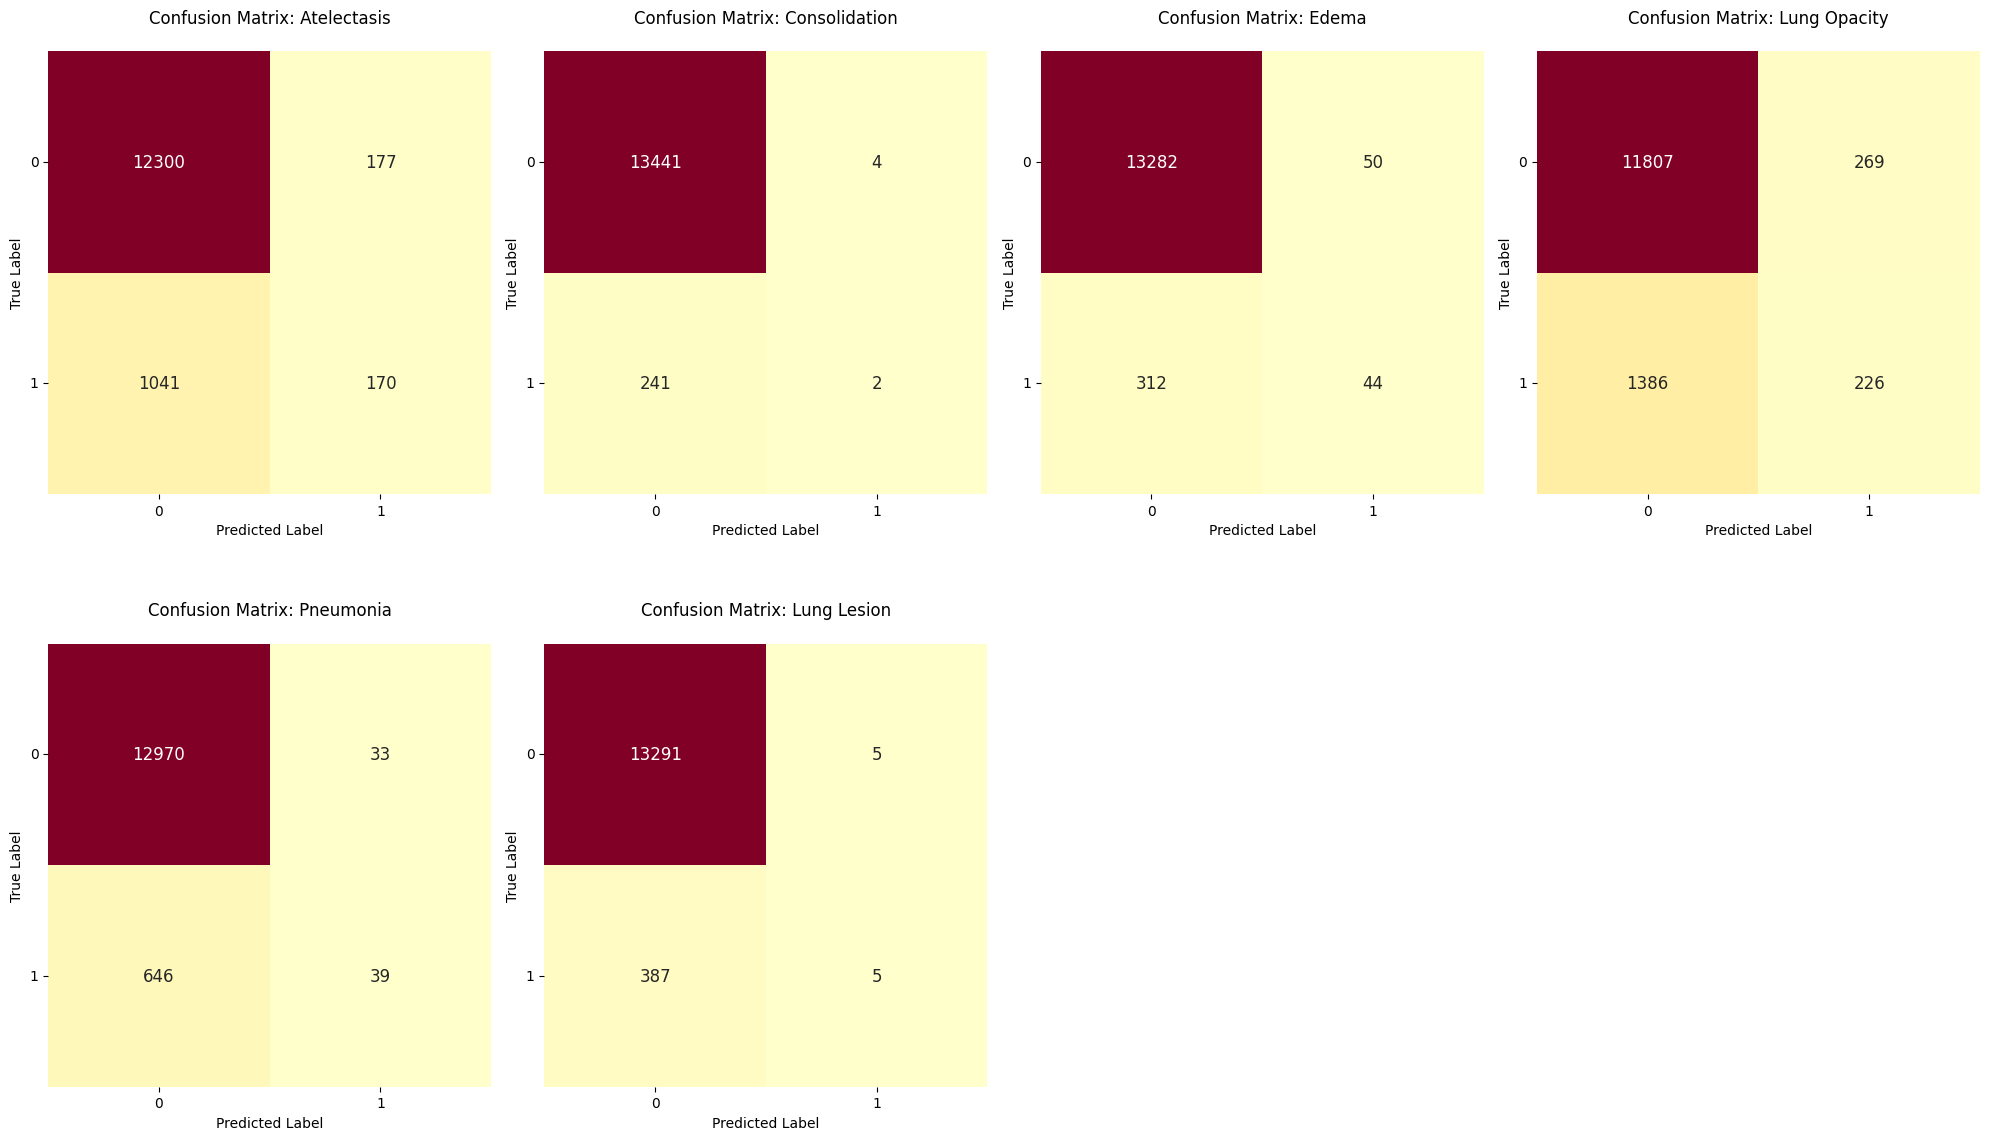

               precision    recall  f1-score   support

  Atelectasis       0.49      0.14      0.22      1211
Consolidation       0.33      0.01      0.02       243
        Edema       0.47      0.12      0.20       356
 Lung Opacity       0.46      0.14      0.21      1612
    Pneumonia       0.54      0.06      0.10       685
  Lung Lesion       0.50      0.01      0.02       392

    micro avg       0.47      0.11      0.18      4499
    macro avg       0.46      0.08      0.13      4499
 weighted avg       0.48      0.11      0.17      4499
  samples avg       0.03      0.02      0.03      4499



In [52]:
model_train_lung_diseases = joblib.load("model_xgb_lung_diseases_v2.pkl")

validate_model(model_train_lung_diseases,lung_diseases_valid,x_valid_lung_diseases,y_valid_lung_diseases)

Validation loss: 0.12031933286542218
(13688, 3)
[0 0 0]

Model Performance Metrics:

Pleural Effusion:
Accuracy: 0.9368
Precision: 0.6850
Recall: 0.4228
F1-score: 0.5229

Pleural Other:
Accuracy: 0.9909
Precision: 0.2500
Recall: 0.0081
F1-score: 0.0157

Pneumothorax:
Accuracy: 0.9871
Precision: 0.4783
Recall: 0.0629
F1-score: 0.1111

Confusion Matrices for Each Pathology:

Pleural Effusion:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[12349   218]
 [  647   474]]

Pleural Other:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13562     3]
 [  122     1]]

Pneumothorax:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13501    12]
 [  164    11]]


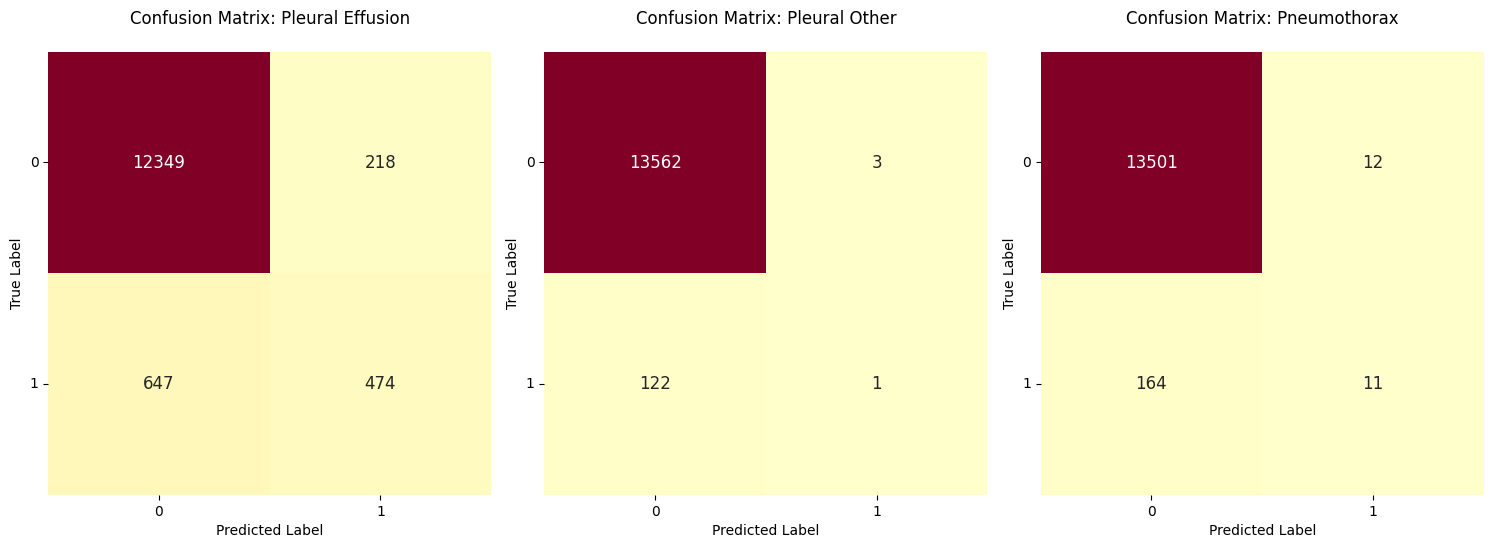

                  precision    recall  f1-score   support

Pleural Effusion       0.68      0.42      0.52      1121
   Pleural Other       0.25      0.01      0.02       123
    Pneumothorax       0.48      0.06      0.11       175

       micro avg       0.68      0.34      0.45      1419
       macro avg       0.47      0.16      0.22      1419
    weighted avg       0.62      0.34      0.43      1419
     samples avg       0.04      0.03      0.03      1419



In [35]:
model_train_pleural_related = joblib.load("model_xgb_pleural_related_v2.pkl")

validate_model(model_train_pleural_related,pleural_related_valid,x_valid_pleural_related,y_valid_pleural_related)

Validation loss: 0.18483238335379099
(13688, 2)
[0 0]

Model Performance Metrics:

Cardiomegaly:
Accuracy: 0.9215
Precision: 0.5147
Recall: 0.1613
F1-score: 0.2456

Enlarged Cardiomediastinum:
Accuracy: 0.9862
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Confusion Matrices for Each Pathology:

Cardiomegaly:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[12438   165]
 [  910   175]]

Enlarged Cardiomediastinum:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13499     0]
 [  189     0]]


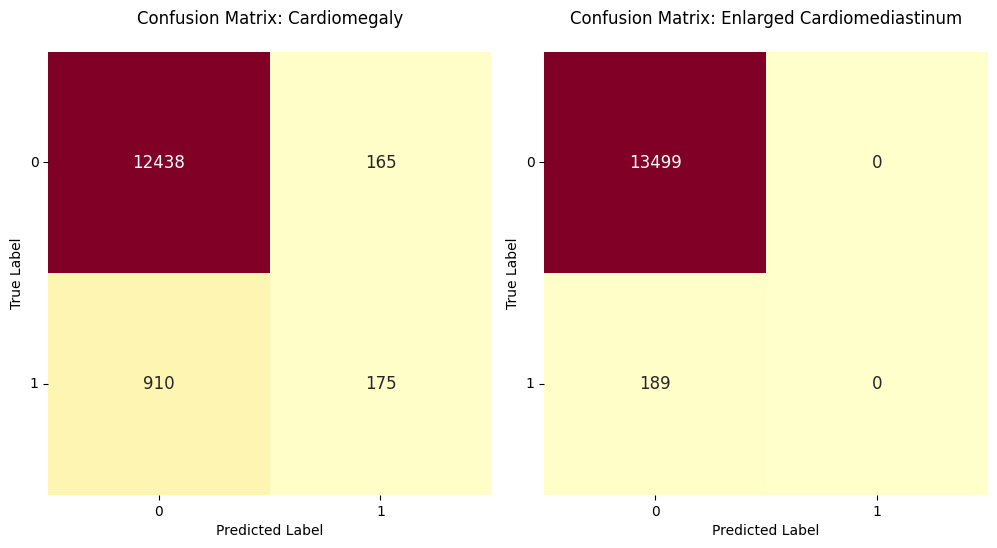

                            precision    recall  f1-score   support

              Cardiomegaly       0.51      0.16      0.25      1085
Enlarged Cardiomediastinum       0.00      0.00      0.00       189

                 micro avg       0.51      0.14      0.22      1274
                 macro avg       0.26      0.08      0.12      1274
              weighted avg       0.44      0.14      0.21      1274
               samples avg       0.01      0.01      0.01      1274



In [37]:
model_train_cardiac_mediastinal = joblib.load("model_xgb_cardiac_mediastinal_v2.pkl")

validate_model(model_train_cardiac_mediastinal,cardiac_mediastinal_valid,x_valid_cardiac_mediastinal,y_valid_cardiac_mediastinal)

Validation loss: 0.1545122270990195
(13688, 1)
[0]

Model Performance Metrics:

Fracture:
Accuracy: 0.9789
Precision: 1.0000
Recall: 0.0103
F1-score: 0.0203

Confusion Matrices for Each Pathology:

Fracture:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13396     0]
 [  289     3]]


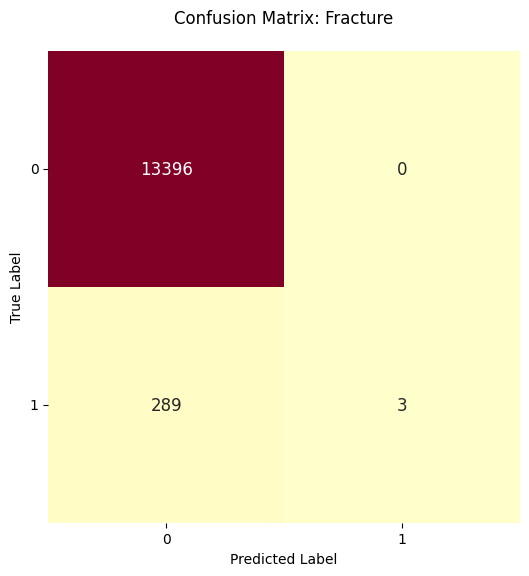

ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [41]:
model_train_fracture = joblib.load("model_xgb_fracture_v2.pkl")

validate_model(model_train_fracture, fracture_valid,x_valid_fracture,y_valid_fracture)

Validation loss: 0.1870405899816111
(13688, 1)
[0]

Model Performance Metrics:

Support Devices:
Accuracy: 0.9580
Precision: 0.4904
Recall: 0.1346
F1-score: 0.2112

Confusion Matrices for Each Pathology:

Support Devices:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[13036    80]
 [  495    77]]


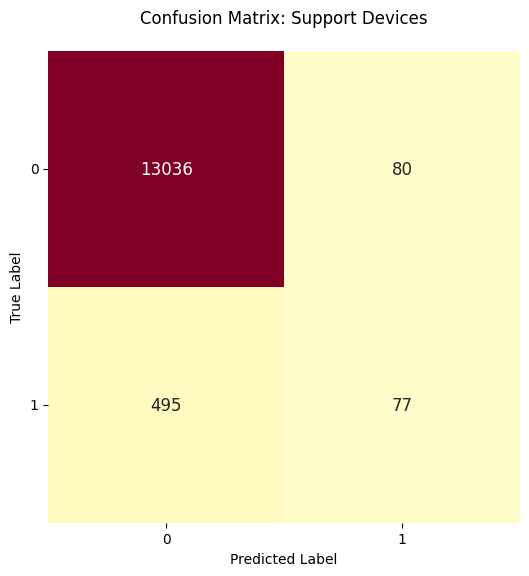

ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [42]:
model_train_support_devices = joblib.load("model_xgb_support_devices_v2.pkl")

validate_model(model_train_support_devices,support_devices_valid,x_valid_support_devices,y_valid_support_devices)

In [7]:
x_test_lung_diseases = np.stack([sample['embedding'].numpy() for sample in lung_diseases_test])  # shape: [n_samples, embedding_dim]
y_test_lung_diseases = np.stack([sample['lab'] for sample in lung_diseases_test]) # shape: [n_samples, n_labels]  
print(x_test_lung_diseases.shape)
print(y_test_lung_diseases.shape) 

x_test_pleural_related = np.stack([sample['embedding'].numpy() for sample in pleural_related_test])  # shape: [n_samples, embedding_dim]
y_test_pleural_related = np.stack([sample['lab'] for sample in pleural_related_test]) # shape: [n_samples, n_labels]  
print(x_test_pleural_related.shape)
print(y_test_pleural_related.shape)

x_test_cardiac_mediastinal = np.stack([sample['embedding'].numpy() for sample in cardiac_mediastinal_test])  # shape: [n_samples, embedding_dim]
y_test_cardiac_mediastinal = np.stack([sample['lab'] for sample in cardiac_mediastinal_test]) # shape: [n_samples, n_labels]  
print(x_test_cardiac_mediastinal.shape)
print(y_test_cardiac_mediastinal.shape)

x_test_fracture = np.stack([sample['embedding'].numpy() for sample in fracture_test])  # shape: [n_samples, embedding_dim]
y_test_fracture = np.stack([sample['lab'] for sample in fracture_test]) # shape: [n_samples, n_labels]  
print(x_test_fracture.shape)
print(y_test_fracture.shape)

x_test_support_devices = np.stack([sample['embedding'].numpy() for sample in support_devices_test])  # shape: [n_samples, embedding_dim]
y_test_support_devices = np.stack([sample['lab'] for sample in support_devices_test]) # shape: [n_samples, n_labels]  
print(x_test_support_devices.shape)
print(y_test_support_devices.shape)

(9126, 1376)
(9126, 6)
(9126, 1376)
(9126, 3)
(9126, 1376)
(9126, 2)
(9126, 1376)
(9126, 1)
(9126, 1376)
(9126, 1)


## Model testing

lung_diseases
Validation loss: 0.2315221308268032
(9126, 6)
[0 0 0 0 0 0]

Model Performance Metrics:

Atelectasis:
Accuracy: 0.9061
Precision: 0.4962
Recall: 0.1520
F1-score: 0.2328

Consolidation:
Accuracy: 0.9818
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Edema:
Accuracy: 0.9744
Precision: 0.4648
Recall: 0.1441
F1-score: 0.2200

Lung Opacity:
Accuracy: 0.8765
Precision: 0.4884
Recall: 0.1313
F1-score: 0.2069

Pneumonia:
Accuracy: 0.9536
Precision: 0.6111
Recall: 0.0510
F1-score: 0.0942

Lung Lesion:
Accuracy: 0.9704
Precision: 0.6000
Recall: 0.0111
F1-score: 0.0217

Confusion Matrices for Each Pathology:

Atelectasis:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8139  132]
 [ 725  130]]

Consolidation:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8960    0]
 [ 166    0]]

Edema:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8859   38]
 [ 196   33]]

Lung Opacity:
[[True Negative, False Positive]
 [False N

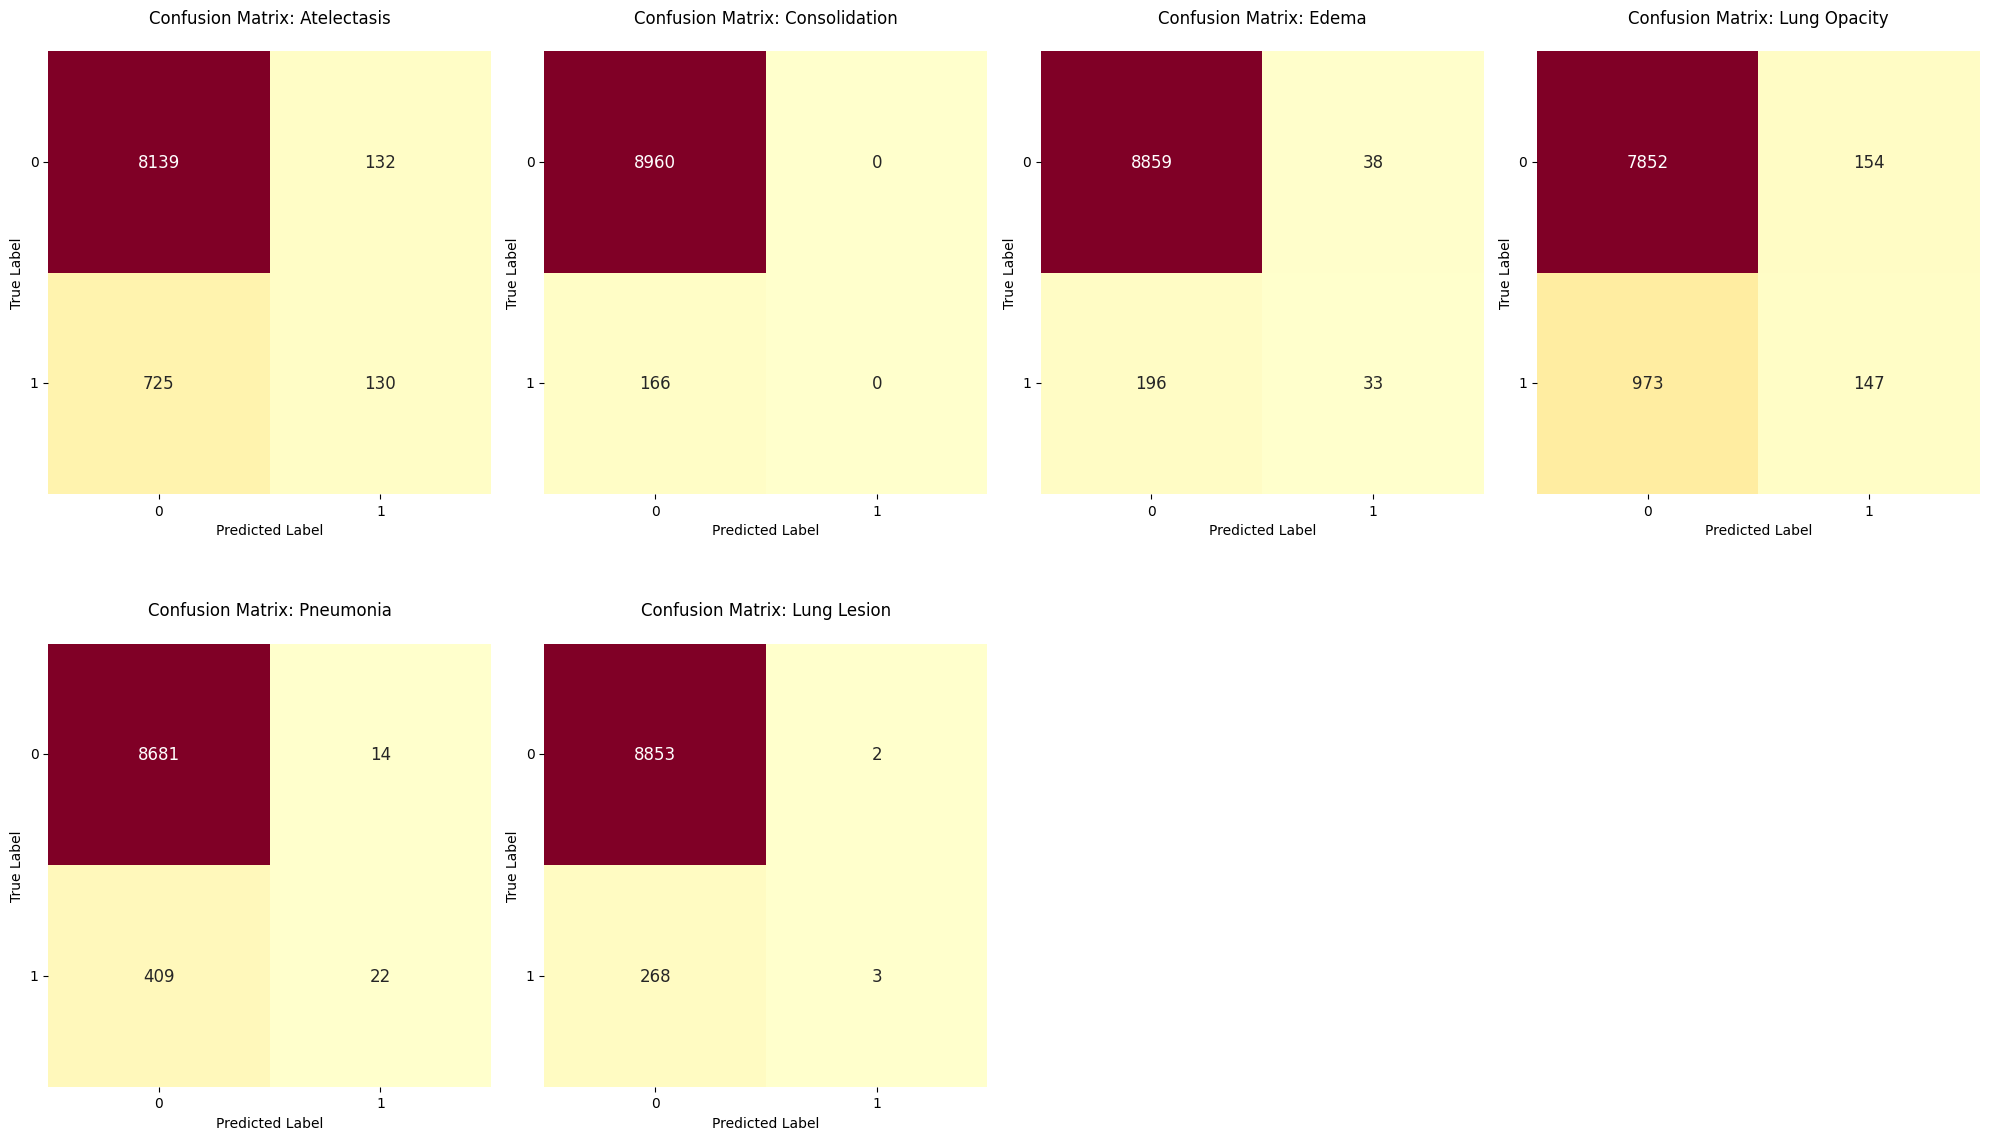

               precision    recall  f1-score   support

  Atelectasis       0.50      0.15      0.23       855
Consolidation       0.00      0.00      0.00       166
        Edema       0.46      0.14      0.22       229
 Lung Opacity       0.49      0.13      0.21      1120
    Pneumonia       0.61      0.05      0.09       431
  Lung Lesion       0.60      0.01      0.02       271

    micro avg       0.50      0.11      0.18      3072
    macro avg       0.44      0.08      0.13      3072
 weighted avg       0.49      0.11      0.17      3072
  samples avg       0.03      0.02      0.03      3072

pleural_related
Validation loss: 0.11792708885347652
(9126, 3)
[0 0 0]

Model Performance Metrics:

Pleural Effusion:
Accuracy: 0.9336
Precision: 0.6293
Recall: 0.4461
F1-score: 0.5221

Pleural Other:
Accuracy: 0.9910
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Pneumothorax:
Accuracy: 0.9886
Precision: 0.5556
Recall: 0.0476
F1-score: 0.0877

Confusion Matrices for Each Pathology:

P

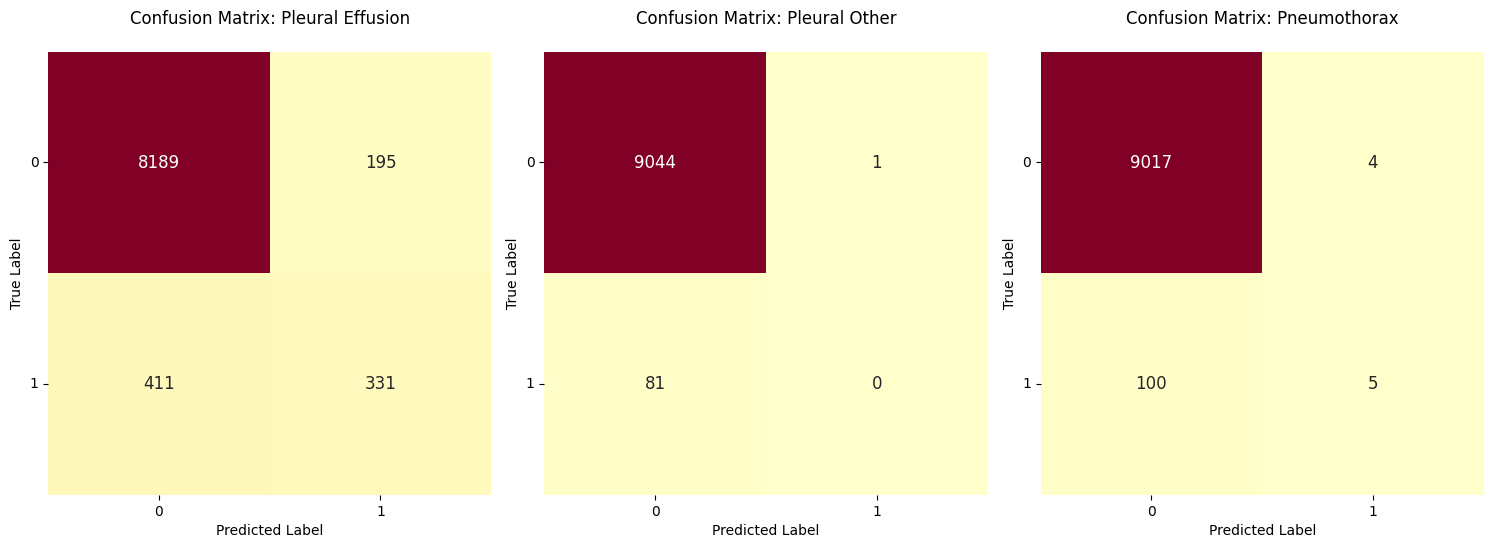

                  precision    recall  f1-score   support

Pleural Effusion       0.63      0.45      0.52       742
   Pleural Other       0.00      0.00      0.00        81
    Pneumothorax       0.56      0.05      0.09       105

       micro avg       0.63      0.36      0.46       928
       macro avg       0.39      0.16      0.20       928
    weighted avg       0.57      0.36      0.43       928
     samples avg       0.04      0.03      0.03       928

cardiac_mediastinal
Validation loss: 0.19493432904634822
(9126, 2)
[0 0]

Model Performance Metrics:

Cardiomegaly:
Accuracy: 0.9192
Precision: 0.5541
Recall: 0.1616
F1-score: 0.2503

Enlarged Cardiomediastinum:
Accuracy: 0.9848
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Confusion Matrices for Each Pathology:

Cardiomegaly:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8266   99]
 [ 638  123]]

Enlarged Cardiomediastinum:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8987   

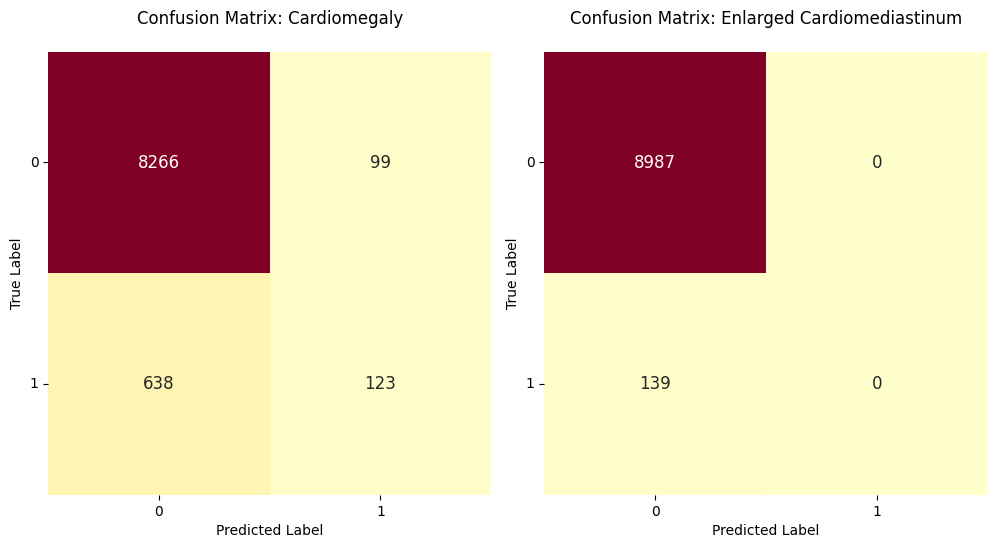

                            precision    recall  f1-score   support

              Cardiomegaly       0.55      0.16      0.25       761
Enlarged Cardiomediastinum       0.00      0.00      0.00       139

                 micro avg       0.55      0.14      0.22       900
                 macro avg       0.28      0.08      0.13       900
              weighted avg       0.47      0.14      0.21       900
               samples avg       0.01      0.01      0.01       900

fracture
Validation loss: 0.1493917430662245
(9126, 1)
[0]

Model Performance Metrics:

Fracture:
Accuracy: 0.9797
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Confusion Matrices for Each Pathology:

Fracture:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8941    1]
 [ 184    0]]


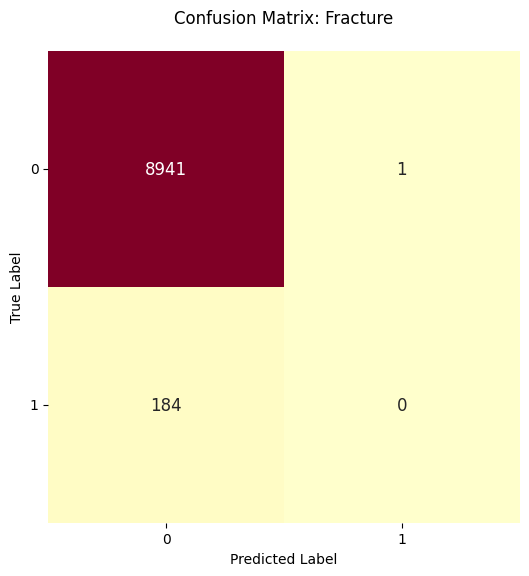

ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [20]:
print("lung_diseases")
model_train_lung_diseases = joblib.load("model_xgb_lung_diseases_v2.pkl")
validate_model(model_train_lung_diseases,lung_diseases_test,x_test_lung_diseases,y_test_lung_diseases)

print("pleural_related")
model_train_pleural_related = joblib.load("model_xgb_pleural_related_v2.pkl")
validate_model(model_train_pleural_related,pleural_related_test,x_test_pleural_related,y_test_pleural_related)

print("cardiac_mediastinal")
model_train_cardiac_mediastinal = joblib.load("model_xgb_cardiac_mediastinal_v2.pkl")
validate_model(model_train_cardiac_mediastinal,cardiac_mediastinal_test,x_test_cardiac_mediastinal,y_test_cardiac_mediastinal)


fracture
Validation loss: 0.1493917430662245
(9126, 1)
[0]

Model Performance Metrics:

Fracture:
Accuracy: 0.9797
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Confusion Matrices for Each Pathology:

Fracture:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8941    1]
 [ 184    0]]


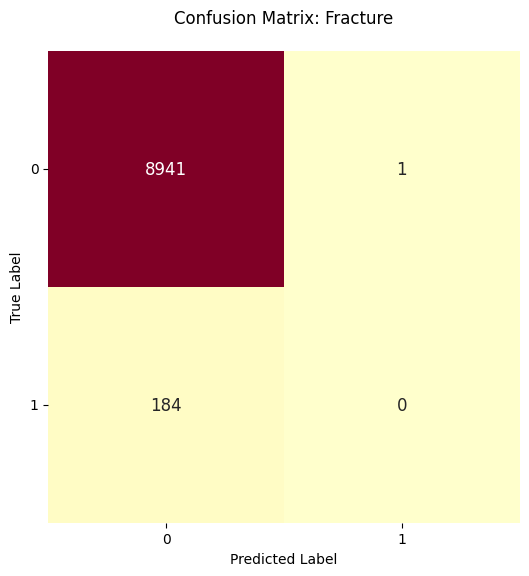

ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [21]:
print("fracture")
model_train_fracture = joblib.load("model_xgb_fracture_v2.pkl")
validate_model(model_train_fracture,fracture_test,x_test_fracture,y_test_fracture)

support_devices
Validation loss: 0.18646436838373948
(9126, 1)
[0]

Model Performance Metrics:

Support Devices:
Accuracy: 0.9541
Precision: 0.3871
Recall: 0.0905
F1-score: 0.1466

Confusion Matrices for Each Pathology:

Support Devices:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8671   57]
 [ 362   36]]


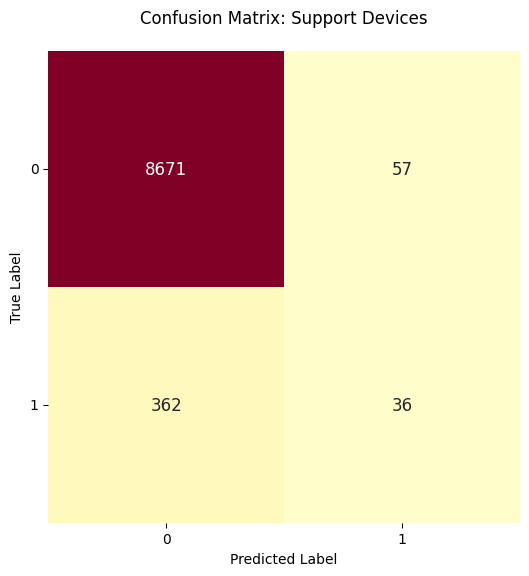

ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [22]:
print("support_devices")
model_train_support_devices = joblib.load("model_xgb_support_devices_v2.pkl")
validate_model(model_train_support_devices,support_devices_test,x_test_support_devices,y_test_support_devices)

In [ ]:
'''
# Load Lung Diseases
lung_diseases_train = datasets["Lung Diseases"]["train"]
lung_diseases_valid = datasets["Lung Diseases"]["valid"]
lung_diseases_test = datasets["Lung Diseases"]["test"]
# Load Pleural-Related
pleural_related_train = datasets["Pleural-Related"]["train"]
pleural_related_valid = datasets["Pleural-Related"]["valid"]
pleural_related_test = datasets["Pleural-Related"]["test"]
# Load Cardiac and Mediastinal
cardiac_mediastinal_train = datasets["Cardiac and Mediastinal"]["train"]
cardiac_mediastinal_valid = datasets["Cardiac and Mediastinal"]["valid"]
cardiac_mediastinal_test = datasets["Cardiac and Mediastinal"]["test"]  
#Load Fracture
fracture_train = datasets["Fracture"]["train"]
fracture_valid = datasets["Fracture"]["valid"]
fracture_test = datasets["Fracture"]["test"]
#Load Support Devices
support_devices_train = datasets["Support Devices"]["train"]
support_devices_valid = datasets["Support Devices"]["valid"]
support_devices_test = datasets["Support Devices"]["test"]
'''

In [6]:
'''
# Setting the search space
parameters_B = {
    'estimator__learning_rate': Real(0.01, 1.0, 'uniform'),
    'estimator__max_depth': Integer(2, 12),
    'estimator__n_estimators': Integer(50, 5000)
   }

# Wrapping everything up into the Bayesian optimizer
BestXGBoost = BayesSearchCV(estimator=XGBoostModel,                                  
                    search_spaces=parameters_B,                      
                    scoring=scorer,                                  
                    cv=cv,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    verbose=3,
                    #iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability
'''

"\n# Setting the search space\nparameters_B = {\n    'estimator__learning_rate': Real(0.01, 1.0, 'uniform'),\n    'estimator__max_depth': Integer(2, 12),\n    'estimator__n_estimators': Integer(50, 5000)\n   }\n\n# Wrapping everything up into the Bayesian optimizer\nBestXGBoost = BayesSearchCV(estimator=XGBoostModel,                                  \n                    search_spaces=parameters_B,                      \n                    scoring=scorer,                                  \n                    cv=cv,                                           \n                    n_iter=120,                                       # max number of trials\n                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time\n                    n_jobs=-1,                                        # number of jobs\n                    verbose=3,\n                    #iid=False,                                        # if not iid it op